In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
import os

In [3]:
from scipy.stats import multivariate_normal

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
class Obj:
    pass

In [6]:
params = Obj()
params.input_dim = 784 
params.n_labels = 10 
params.hidden_encoder_dim = 400
params.hidden_decoder_dim = 400
params.latent_dim = 15
params.lam = 1e-3

In [7]:
def weight_variable(shape, stddev = .1):
    xav_stddev = stddev * np.sqrt( 1. / shape[0])
    initial = tf.random_normal(shape = shape, stddev = xav_stddev)
    return tf.Variable(initial)

In [8]:
gate_x = tf.placeholder(tf.float32)
gate_y = tf.placeholder(tf.float32)

In [9]:
x = tf.placeholder(dtype=tf.float32, shape=[None, params.input_dim])
y = tf.placeholder(dtype=tf.float32, shape=[None, params.n_labels])
l2_loss = tf.constant(0.0)

In [10]:
# Hidden layer encoder
W_encoder_input_hidden = weight_variable([params.input_dim, params.hidden_encoder_dim])
l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)
hidden_encoder = tf.nn.relu(tf.matmul(tf.multiply(x, gate_x), W_encoder_input_hidden)) 

In [11]:
# Hidden y layer encoder
W_encoder_y_hidden = weight_variable([params.n_labels, params.hidden_encoder_dim])
l2_loss += tf.nn.l2_loss(W_encoder_y_hidden)
hidden_y_encoder = tf.nn.relu(tf.matmul(tf.multiply(y, gate_y), W_encoder_y_hidden)) 

In [12]:
# Mu encoder
W_encoder_hidden_mu = weight_variable([params.hidden_encoder_dim, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)

In [13]:
# Mu y encoder
#W_encoder_hidden_y_mu = weight_variable([params.hidden_encoder_dim, params.latent_dim])
W_encoder_hidden_y_mu = weight_variable([params.n_labels, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_y_mu)

In [14]:
mu_encoder_x = tf.matmul(hidden_encoder, W_encoder_hidden_mu) 
#mu_encoder_y = tf.matmul(hidden_y_encoder, W_encoder_hidden_y_mu)
mu_encoder_y = tf.matmul(tf.multiply(y, gate_y), W_encoder_hidden_y_mu)


#mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + tf.matmul(y, W_encoder_hidden_y_mu)

In [15]:
# Sigma encoder
W_encoder_hidden_logvar = weight_variable([params.hidden_encoder_dim, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)

In [16]:
# Sigma y encoder
#W_encoder_hidden_y_logvar = weight_variable([params.hidden_encoder_dim, params.latent_dim])
W_encoder_hidden_y_logvar = weight_variable([params.n_labels, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_y_logvar)

In [17]:
logvar_encoder_x = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) 
var_x = tf.exp(logvar_encoder_x)

#logvar_encoder_y = tf.matmul(hidden_y_encoder, W_encoder_hidden_y_logvar)
logvar_encoder_y = tf.matmul(tf.multiply(y, gate_y), W_encoder_hidden_y_logvar)
var_y = tf.exp(logvar_encoder_y)

logvar_encoder = tf.add(tf.add(logvar_encoder_x, logvar_encoder_y), - tf.log(tf.add(var_x, var_y)))

alpha_x = tf.divide(var_y, tf.add(var_x, var_y))
alpha_y = tf.divide(var_x, tf.add(var_x, var_y))
#logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + tf.matmul(y, W_encoder_hidden_y_logvar)
mu_encoder = tf.add(tf.multiply(alpha_x, mu_encoder_x), tf.multiply(alpha_y, mu_encoder_y)) 


In [18]:
# Sample epsilon
epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')
# Sample latent variable
std_encoder = tf.exp(0.5 * logvar_encoder)
z = mu_encoder + tf.multiply(std_encoder, epsilon)

In [19]:
# Hidden y reconstruction layer
W_decoder_z_y_hidden = weight_variable([params.latent_dim, params.hidden_decoder_dim])
l2_loss += tf.nn.l2_loss(W_decoder_z_y_hidden)
hidden_y_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_y_hidden))

In [20]:
# y reconstruction layer 
W_decoder_y_reconstruction = weight_variable([params.hidden_decoder_dim, params.n_labels])
l2_loss += tf.nn.l2_loss(W_decoder_y_reconstruction)
y_hat_logit = tf.matmul(hidden_y_decoder, W_decoder_y_reconstruction)

In [21]:
# Hidden layer decoder
W_decoder_z_hidden = weight_variable([params.latent_dim, params.hidden_decoder_dim])
l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)
hidden_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_hidden))

In [22]:
# Reconstruction layer 
W_decoder_hidden_reconstruction = weight_variable([params.hidden_decoder_dim, params.input_dim])
l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)
x_hat_logit = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) 

## Loss

In [23]:
# Loss
# KL Divergence (Log Gaussian)
KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder)) #, reduction_indices=1)
#KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder)) #, reduction_indices=1)
# Reconstruction Loss
BCE_x = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat_logit, labels=x))#, reduction_indices=1)
#BCE_x = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat_logit, labels=x)) #, reduction_indices=1)
BCE_y = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat_logit, labels=y))#, reduction_indices=1)
#BCE_y = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat_logit, labels=y)) #, reduction_indices=1)
#BCE_y = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat_logit, labels=y))
loss = tf.reduce_mean(BCE_x + BCE_y + KLD)
loss_x = tf.reduce_mean(BCE_x + KLD) # ZERO_Y (x predit x)
loss_y = tf.reduce_mean(BCE_y + KLD) # ZERO_X (y predit y)
regularized_loss = loss + params.lam * l2_loss

## Train

In [24]:
# Train
loss_summ = tf.summary.scalar("lowerbound", loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(regularized_loss)
# add op for merging summary
summary_op = tf.summary.merge_all()

In [25]:
## 

In [26]:
# add Saver ops
saver = tf.train.Saver()

In [27]:
n_steps = int(1e6)
batch_size = 100

In [28]:
sess = tf.InteractiveSession()

In [29]:
summary_writer = tf.summary.FileWriter('experiment',
                                      graph=sess.graph)
if os.path.isfile("save/model.ckpt"):
    print("Restoring saved parameters")
    saver.restore(sess, "save/model.ckpt")
else:
    print("Initializing parameters")
    sess.run(tf.global_variables_initializer())

Initializing parameters


In [65]:
for step in range(1, n_steps):
    batch = mnist.train.next_batch(batch_size)
    if step % 3 == 0 : #10 == 9:
        feed_dict = {x: batch[0], y:batch[1], gate_x : 1, gate_y : 1}
        _, cur_loss, summary_str = sess.run([train_step, loss, summary_op], feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
    elif step % 3 == 1:
        # x predit x
        feed_dict = {x: batch[0], y:batch[1] , gate_x : 1, gate_y : 0}
        _, cur_loss, summary_str = sess.run([train_step, loss, summary_op], feed_dict=feed_dict)
    else:
        # y predit y
        feed_dict = {x: batch[0], y:batch[1], gate_x : 0, gate_y : 1}
        _, cur_loss, summary_str = sess.run([train_step, loss, summary_op], feed_dict=feed_dict)
    if step % 50 == 0:
        save_path = saver.save(sess, "save/model.ckpt")
        sys.stdout.write("\rStep {0} | Loss: {1}".format(step, cur_loss))


Step 68400 | Loss: 10724.9130859375

KeyboardInterrupt: 

In [66]:
batch = mnist.train.next_batch(batch_size)
liste_z = z.eval(feed_dict={x: batch[0], y:batch[1], gate_x : 1, gate_y : 1})

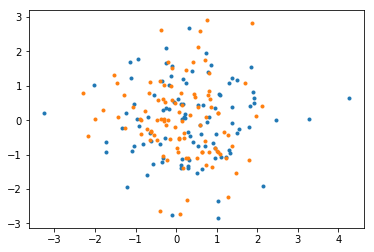

In [67]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')
ref = np.random.randn(batch_size, params.latent_dim)
plt.plot(ref[:,0], ref[:,1], '.')

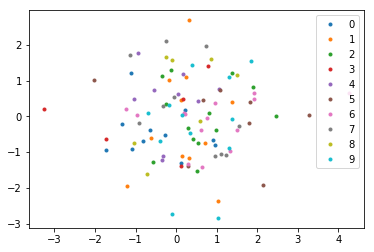

In [68]:
z_cat = {}
for i in range(10):
    z_cat[i] = []
for i in range(len(liste_z)):
    index = np.where(batch[1][i] == 1)[0][0]
    z_cat[index] += [liste_z[i]]
for i in range(10):
    z_aff = np.transpose(z_cat[i])
    plt.plot(z_aff[0,:], z_aff[1,:], '.')
plt.legend((0,1,2,3,4,5,6,7,8,9))

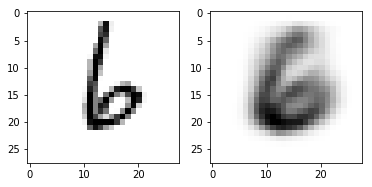

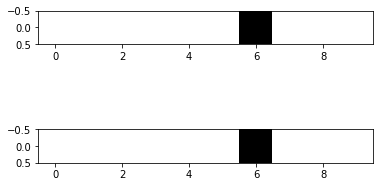

In [76]:
GATE_X = 0
GATE_Y = 1
x_hat_logit_test, y_hat_logit_test = sess.run((x_hat_logit, y_hat_logit), feed_dict={x: batch[0] , y:batch[1], gate_x : GATE_X, gate_y : GATE_Y})
x_hat = sess.run(tf.nn.sigmoid(x_hat_logit_test))
y_hat = sess.run(tf.nn.sigmoid(y_hat_logit_test))

i = 0
plt.subplot(1,2,1)
plt.imshow(batch[0][i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_hat[i].reshape((28, 28)), cmap = 'gray_r')
plt.figure()
plt.subplot(2,1,1)
plt.imshow(batch[1][i].reshape((1, 10)), cmap = 'gray_r')
plt.subplot(2,1,2)
plt.imshow(y_hat[i].reshape((1, 10)), cmap = 'gray_r')

In [ ]:
i = 8

y_hat[i]

categ =  9
mu_x =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
std_x =  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
mu_y =  [ 0.24544969 -0.02370235  0.88270497 -0.12417275 -0.66563612 -0.79920268
 -1.82723498 -0.19667277 -1.6502924  -0.58115369 -0.2868551  -1.48005247
 -0.37671047  1.04829991 -0.94925684]
std_y =  [ 1.50362182  1.4907223   0.43082592  1.26234257  0.81856042  0.44133335
  0.66354489  1.45908701  0.35598001  0.58536315  1.52387607  0.35508883
  1.30584049  0.3575843   1.30431759]
mu =  [ 0.07527103 -0.00735583  0.74451482 -0.04787829 -0.39857471 -0.66891474
 -1.26865602 -0.06285614 -1.46468496 -0.43284082 -0.08634496 -1.31433094
 -0.13925321  0.92945391 -0.35141465]
std =  [ 0.83266687  0.83045655  0.39566779  0.78385079  0.63341326  0.40376034
  0.55289805  0.8248651   0.33536467  0.5051775   0.83605891  0.33461916
  0.79394221  0.33670503  0.79359961]


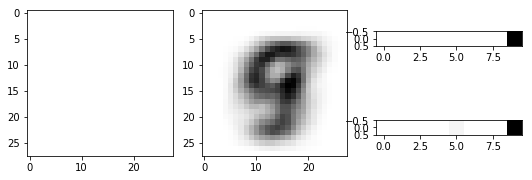

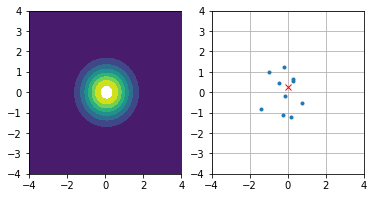

In [83]:
GATE_X = 0
GATE_Y = 1
i = 2

#x_hat, y_hat = tf.nn.sigmoid((x_hat_logit, y_hat_logit)).eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})
# = tf.nn.sigmoid().eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})
x_hat_logit_test, y_hat_logit_test, mu_x,         var_x_test, mu_y,         var_y_test, mu_test,    std_test,    z_test = sess.run(\
(x_hat_logit,     y_hat_logit,      mu_encoder_x, var_x,      mu_encoder_y, var_y,      mu_encoder, std_encoder, z), \
                                          feed_dict={x: batch[0], y:batch[1], \
                                          gate_x : GATE_X, gate_y : GATE_Y})
x_hat, y_hat = tf.nn.sigmoid(x_hat_logit_test), tf.nn.sigmoid(y_hat_logit_test)

plt.figure(figsize = (12,3))
plt.subplot(1,4,1)
plt.imshow(batch[0][i].reshape((28, 28)) * GATE_X, cmap = 'gray_r')
plt.subplot(1,4,2)
plt.imshow(x_hat[i].eval().reshape((28, 28)), cmap = 'gray_r')
plt.subplot(2,4,3)
plt.imshow(batch[1][i].reshape((1, 10)) * GATE_Y, cmap = 'gray_r')
plt.subplot(2,4,7)
plt.imshow(y_hat[i].eval().reshape((1, 10)) , cmap = 'gray_r')


print('categ = ', np.where(batch[1][i] == 1)[0][0])
#mu_test = mu_encoder.eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})[i]
print('mu_x = ', mu_x[i])
print('std_x = ', np.sqrt(var_x_test[i]))
print('mu_y = ', mu_y[i])
print('std_y = ', np.sqrt(var_y_test[i]))
print('mu = ', mu_test[i])
#std_test = std_encoder.eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})[i]
print('std = ', std_test[i])

DIM1 = 0
DIM2 = 1
axe_x, axe_y = np.mgrid[-4:4:.01, -4:4:.01]
q = multivariate_normal(mu_test[i], std_test[i]**2 * np.eye(params.latent_dim))
pos = np.empty(axe_x.shape + (params.latent_dim,))
pos[:, :, DIM1] = axe_x; pos[:, :, DIM2] = axe_y

plt.figure(figsize = (6, 3))
plt.subplot(1,2,1)
plt.contourf(axe_x, axe_y, q.pdf(pos))
ax = plt.subplot(1,2,2)
spl = q.rvs(10)
plt.plot(spl[:,DIM1], spl[:,DIM2], '.')
plt.plot(z_test[i,DIM1], z_test[i,DIM2], 'xr')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

In [ ]:
hidden_y_encoder.eval(feed_dict = {y : batch[1]})[i]

In [ ]:
KLD_test, BCE_x_test, BCE_y_test = sess.run((KLD, BCE_x, BCE_y), feed_dict={x: batch[0] , y:batch[1]})


In [ ]:
BCE_x_test

In [ ]:
var_x_test

In [ ]:
KLD_test